## Testing Method Module
---

In [1]:
#import crowded.simulate as cs
#import crowded.method as cm
import time, sys
sys.path.insert(0, '/Users/pedrohserrano/crowdED/crowded')
import simulate as cs
import method as cm
import make as mk
from pycm import *
import pandas as pd

#### Simulate the tasks

In [2]:
total_tasks = 415 
p_hard_tasks = 0.4
number_of_valid_answers = 5
df_tasks = cs.Tasks(number_of_valid_answers).create(total_tasks, p_hard_tasks)
df_tasks.head()

task_id true_answers label_task  prob_task
task_id                                                                
task_rMrKPk9JLATQ  task_rMrKPk9JLATQ        notes  hard_task       0.30
task_vnzwja8ynWAU  task_vnzwja8ynWAU         slot  hard_task       0.12
task_YBHvtgM55gMY  task_YBHvtgM55gMY         slot  hard_task       0.25
task_eUAw3NtoBCdm  task_eUAw3NtoBCdm         slot  easy_task       0.89
task_6FGWAqeAeMsi  task_6FGWAqeAeMsi         slot  hard_task       0.26

#### Simulate the workers

In [3]:
total_workers = 40 #50 #30
workers = cs.Workers().create(total_workers)
workers.head()

prob_worker     worker_id
worker_id                              
P5BXhUuwDgNr     0.961699  P5BXhUuwDgNr
cQ2ANmRBvuE8     0.883109  cQ2ANmRBvuE8
6A7QbkyqyEF5     0.925251  6A7QbkyqyEF5
bscQC7V7Uvm6     0.969707  bscQC7V7Uvm6
yAygvzPrLTnN     0.948989  yAygvzPrLTnN

#### Split the tasks

In [4]:
#Tasks Split
PTT = .3
def tasks_split(df, p = PTT):
    _train = df.sample(frac=p, random_state=23)
    _rest = df.loc[df.index.difference(_train.index)]
    return _train, _rest

In [5]:
tasks_train, tasks_rest = tasks_split(df_tasks, .3)

#### Assigning workers to tasks

In [6]:
wpt = 5
#workers per task always smaller than the number of workers
df_tw = cs.AssignTasks(tasks_train, workers, wpt).create()
df_tw.head()

task_id     worker_id true_answers label_task  prob_task  \
0  task_ZT5QGG8xnxGC  X74dpW7xKmMy        notes  easy_task       0.86   
1  task_ZT5QGG8xnxGC  L5KTXFDr4tBm        notes  easy_task       0.86   
2  task_ZT5QGG8xnxGC  CQnVbYnRiunG        notes  easy_task       0.86   
3  task_ZT5QGG8xnxGC  fDCUjL4PTqio        notes  easy_task       0.86   
4  task_ZT5QGG8xnxGC  WBBVJg52Zxbq        notes  easy_task       0.86   

   prob_worker  
0     0.983675  
1     0.923747  
2     0.840299  
3     0.938620  
4     0.957909

#### Compute the probability to assess the tasks

In [7]:
keys = df_tasks['true_answers'].unique()
keys

array(['notes', 'slot', 'recovery', 'tastes', 'fashion'], dtype=object)

In [8]:
cp = cm.ComputeProbability(df_tw['prob_task'], df_tw['prob_worker'], keys)
df_tw['worker_answers'] = cm.WorkerAnswer(df_tw['true_answers'], cp.predict(), keys).match()
df_tw['performance'] = cp.predict()
df_tw.head()

task_id     worker_id true_answers label_task  prob_task  \
0  task_ZT5QGG8xnxGC  X74dpW7xKmMy        notes  easy_task       0.86   
1  task_ZT5QGG8xnxGC  L5KTXFDr4tBm        notes  easy_task       0.86   
2  task_ZT5QGG8xnxGC  CQnVbYnRiunG        notes  easy_task       0.86   
3  task_ZT5QGG8xnxGC  fDCUjL4PTqio        notes  easy_task       0.86   
4  task_ZT5QGG8xnxGC  WBBVJg52Zxbq        notes  easy_task       0.86   

   prob_worker worker_answers  performance  
0     0.983675          notes            1  
1     0.923747          notes            1  
2     0.840299          notes            1  
3     0.938620          notes            1  
4     0.957909          notes            1

#### Assess the performance and get the good workers

In [9]:
perf = cm.Performance(df_tw)
df_workers = perf._workers()
df_workers.head()

worker_id  prob_task  prob_worker  performance worker_ability  task_id
0  X74dpW7xKmMy   0.496429     0.983675          1.0    good_worker       14
1  RyFNiicxckey   0.532857     0.987884          1.0    good_worker       14
2  yAygvzPrLTnN   0.675833     0.948989          1.0    good_worker       12
3  ocjumcMYdgJF   0.554444     0.972627          1.0    good_worker       18
4  kP5Tn6ivA8VH   0.603333     0.846569          1.0    good_worker       21

In [10]:
good_workers = workers.loc[perf.good_workers()]
good_workers

prob_worker     worker_id
worker_id                              
X74dpW7xKmMy     0.983675  X74dpW7xKmMy
gKHB57JPazzP     0.944357  gKHB57JPazzP
fDCUjL4PTqio     0.938620  fDCUjL4PTqio
6UjHABqWvvQL     0.877641  6UjHABqWvvQL
WBBVJg52Zxbq     0.957909  WBBVJg52Zxbq
P5BXhUuwDgNr     0.961699  P5BXhUuwDgNr
7NSUwiG4QCCR     0.954569  7NSUwiG4QCCR
AeLS39WMajp8     0.893302  AeLS39WMajp8
D9xEZpkVhKin     0.924944  D9xEZpkVhKin
L5KTXFDr4tBm     0.923747  L5KTXFDr4tBm

#### Check in case there's undone tasks (no concensus achieved)

In [11]:
tasks = df_tw.groupby('task_id').mean().sort_values('performance', ascending=False)

In [12]:
undone = tasks[tasks['performance'] < 0.5]
if len(undone) > 0:
    #paste undone to tasks_rest
    print('There is {} tasks without concesus'.format(len(undone)))

There is 1 tasks without concesus


#### Assign the good workers to the rest of the tasks

In [13]:
wpt = 5
#workers per task always smaller than the number of workers
df_tw_2 = cs.AssignTasks(tasks_rest, good_workers, wpt).create()
df_tw_2.head()

task_id     worker_id true_answers label_task  prob_task  \
0  task_2EUytNKmRNCM  D9xEZpkVhKin     recovery  easy_task       0.73   
1  task_2EUytNKmRNCM  L5KTXFDr4tBm     recovery  easy_task       0.73   
2  task_2EUytNKmRNCM  7NSUwiG4QCCR     recovery  easy_task       0.73   
3  task_2EUytNKmRNCM  AeLS39WMajp8     recovery  easy_task       0.73   
4  task_2EUytNKmRNCM  6UjHABqWvvQL     recovery  easy_task       0.73   

   prob_worker  
0     0.924944  
1     0.923747  
2     0.954569  
3     0.893302  
4     0.877641

#### Compute probability to the rest of the tasks

In [14]:
cp2 = cm.ComputeProbability(df_tw_2['prob_task'], df_tw_2['prob_worker'], keys)
df_tw_2['worker_answers'] = cm.WorkerAnswer(df_tw_2['true_answers'], cp2.predict(), keys).match()
df_tw_2['performance'] = cp2.predict()
df_tw_2.head()

task_id     worker_id true_answers label_task  prob_task  \
0  task_2EUytNKmRNCM  D9xEZpkVhKin     recovery  easy_task       0.73   
1  task_2EUytNKmRNCM  L5KTXFDr4tBm     recovery  easy_task       0.73   
2  task_2EUytNKmRNCM  7NSUwiG4QCCR     recovery  easy_task       0.73   
3  task_2EUytNKmRNCM  AeLS39WMajp8     recovery  easy_task       0.73   
4  task_2EUytNKmRNCM  6UjHABqWvvQL     recovery  easy_task       0.73   

   prob_worker worker_answers  performance  
0     0.924944       recovery            1  
1     0.923747       recovery            1  
2     0.954569       recovery            1  
3     0.893302       recovery            1  
4     0.877641       recovery            1

#### Merge the data and get the real accuracy

In [15]:
df = df_tw.append(df_tw_2)

In [16]:
from pycm import *
mat = ConfusionMatrix(df['true_answers'].tolist(), df['worker_answers'].tolist())
print(mat.Overall_ACC, mat.matrix())

Predict          fashion  notes    recovery slot     tastes   
Actual
fashion          391      4        2        3        5        
notes            5        422      0        2        6        
recovery         3        3        390      3        6        
slot             1        3        3        414      4        
tastes           6        3        8        0        388      

0.9662650602409638 None


#### Compare with 1 stage

In [17]:
df_tw1 = cs.AssignTasks(df_tasks, workers, wpt).create()
cp1 = cm.ComputeProbability(df_tw1['prob_task'], df_tw1['prob_worker'], keys)
df_tw1['worker_answers'] = cm.WorkerAnswer(df_tw1['true_answers'], cp1.predict(), keys).match()
df_tw1['performance'] = cp1.predict()

In [18]:
mat = ConfusionMatrix(df_tw1['true_answers'].tolist(), df_tw1['worker_answers'].tolist())
print(mat.Overall_ACC, mat.matrix())

Predict          fashion  notes    recovery slot     tastes   
Actual
fashion          392      1        4        2        6        
notes            4        410      7        9        5        
recovery         4        3        389      9        0        
slot             5        10       6        401      3        
tastes           5        9        4        5        382      

0.9513253012048193 None


#####  The accuracy of 1 stage algorithm is lower than the 2 stages algorithm *

---
### Overall Accuracy

In [3]:
total_tasks = 415 
total_workers = 40 
p_hard_tasks = 0.4
PTT = .3
wpt = 5
NK = 5
a = 8

In [1]:
#import crowded.make as mk

In [25]:
import time, sys
sys.path.insert(0, '/Users/pedrohserrano/crowdED/crowded')
import simulate as cs
import method as cm
import make as mk
from pycm import *
import pandas as pd

In [26]:
tasks = [60, 100, 140]
workers = [30, 50, 80, 100]
hard_t = [0.2, 0.8]
prop = [0.2,0.8]
wpt = [5]
key = [3]

In [36]:
def _combinations(tasks, workers, hard_t, prop, wpt, key):
    table = []
    for t in tasks:
        for w in workers:
            for h in hard_t:
                for p in prop:
                    for x in wpt:
                        for k in key:
                            table.append([t, w, h, p, x, k])
    return table



def get_accuracy(tasks, workers, hard_t, prop, wpt, key, stages=2):
    sim = _combinations(tasks, workers, hard_t, prop, wpt, key)
    for idx, l in enumerate(sim):
        mk._update_progress("CrowdED simulation", idx / len(sim))
        try:
            if stages == 2:
                df = mk.crowd_table(total_tasks=l[0], total_workers=l[1], p_hard_tasks=l[2], ptt=l[3], wpt=l[4], nk=l[5])
            else:
                df = mk.crowd_table_one_stage(total_tasks=l[0], total_workers=l[1], p_hard_tasks=l[2], ptt=l[3], wpt=l[4], nk=l[5])
            mat = ConfusionMatrix(df['true_answers'].tolist(), df['worker_answers'].tolist())
            l.insert(6, round(mat.Overall_ACC, 4))
            l.insert(7, round(mat.CrossEntropy, 4))
            l.insert(8, round(sum([i for i in cm.F1.values()]) / len([i for i in cm.F1.values()]), 4))
        except Exception:
            pass
    return sim

In [39]:
sim = _combinations(tasks, workers, hard_t, prop, wpt, key)

In [43]:
sim[0][0]

60

In [ ]:
    
    for idx, l in enumerate(sim):
        mk._update_progress("CrowdED simulation", idx / len(sim))
        try:
            if stages == 2:
                df = mk.crowd_table(total_tasks=l[0], total_workers=l[1], p_hard_tasks=l[2], ptt=l[3], wpt=l[4], nk=l[5])
            else:
                df = mk.crowd_table_one_stage(total_tasks=l[0], total_workers=l[1], p_hard_tasks=l[2], ptt=l[3], wpt=l[4], nk=l[5])
            mat = ConfusionMatrix(df['true_answers'].tolist(), df['worker_answers'].tolist())
            l.insert(6, round(mat.Overall_ACC, 4))
            l.insert(7, round(mat.CrossEntropy, 4))
            l.insert(8, round(sum([i for i in cm.F1.values()]) / len([i for i in cm.F1.values()]), 4))
        except Exception:
            pass

In [ ]:
mk.crowd_table(total_tasks=sim[0][0], total_workers=sim[0][1], p_hard_tasks=sim[0][2], ptt=sim[0][3], wpt=sim[0][0], nk=sim[0][0])

In [37]:
simulations = pd.DataFrame(get_accuracy(tasks, workers, hard_t, prop, wpt, key)).fillna(0)

CrowdED simulation: [####################] 97.92%

the accuracy os not being inserted

In [30]:
#simulations.columns = ['total_tasks', 'total_workers', 'proportion_hard_tasks','proportion_train_tasks', 'workers_per_task', 'total_keys','accuracy','cross_entropy','f1']

In [33]:
#simulations.columns

In [38]:
simulations.head()

0   1    2    3  4  5
0  60  30  0.2  0.2  5  3
1  60  30  0.2  0.8  5  3
2  60  30  0.8  0.2  5  3
3  60  30  0.8  0.8  5  3
4  60  50  0.2  0.2  5  3

In [24]:
#simulations[simulations['accuracy'] == 0]

In [3]:
#simulations.to_csv('../data/df_crowded.csv', index=False)

--- 
### Read the experiment

In [6]:
df_sim = pd.read_csv('../../crowdED/data/20181014_19:07 - simulations.csv')

In [10]:
df_sim.sort_values('accuracy', ascending=False).head(5)

total_tasks  total_workers  proportion_hard_tasks  \
2882           80             70                    0.2   
482            60             50                    0.2   
481            60             50                    0.2   
992            60             70                    0.2   
527            60             50                    0.2   

      proportion_train_tasks  workers_per_task  total_keys  accuracy  
2882                     0.2                 3           7    1.0000  
482                      0.2                 3           7    1.0000  
481                      0.2                 3           5    1.0000  
992                      0.6                 3           7    0.9944  
527                      0.8                 3           7    0.9944

In [4]:
len(df_sim[df_sim['accuracy'] == 0]) / len(df_sim)

0.03420138888888889

In [12]:
len(df_sim)

23040

In [18]:
import seaborn as sns

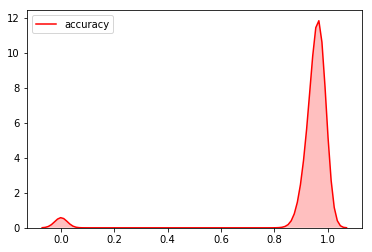

In [11]:
sns.kdeplot(df_sim['accuracy'], shade=True, color="r")

In [14]:
df_sim.columns


Index(['total_tasks', 'total_workers', 'proportion_hard_tasks',
       'proportion_train_tasks', 'workers_per_task', 'total_keys', 'alpha',
       'accuracy'],
      dtype='object')

In [11]:
#df_sim.sort_values('accuracy', ascending=False)

In [12]:
#sns.kdeplot(df_sim['total_tasks'])

In [13]:
top = df_sim.sort_values('accuracy', ascending=False).head(100)

In [16]:
len(df_sim)

15360

In [15]:
#top

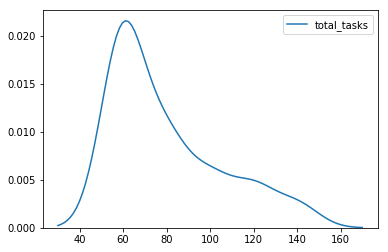

In [13]:
sns.kdeplot(top['total_tasks'])

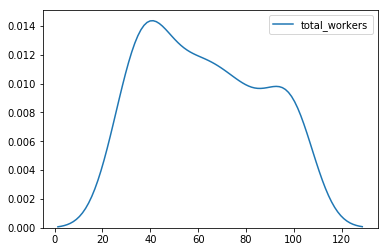

In [14]:
sns.kdeplot(top['total_workers'])

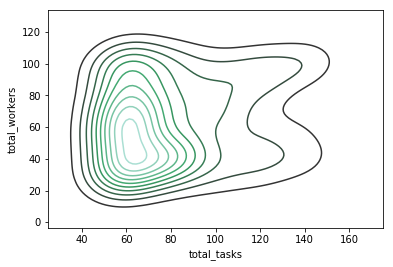

In [32]:
sns.kdeplot(top['total_tasks'], top['total_workers'])

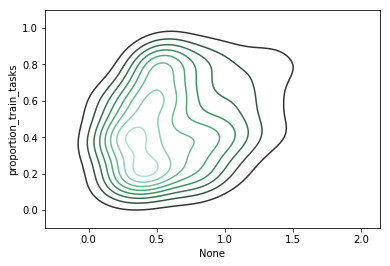

In [20]:
sns.kdeplot((top['total_workers']/top['total_tasks']), top['proportion_train_tasks'])

In [ ]:
4 per 10 the best is train 20% od tasks

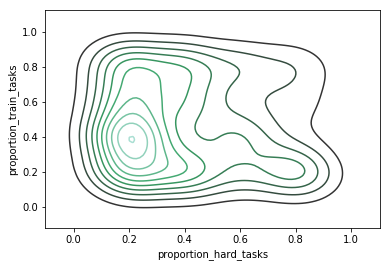

In [33]:
sns.kdeplot(top['proportion_hard_tasks'],top['proportion_train_tasks'])

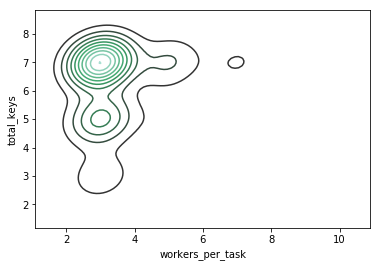

In [31]:
sns.kdeplot(top['workers_per_task'],top['total_keys'])

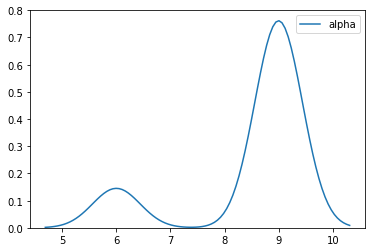

In [30]:
sns.kdeplot(top['alpha'])